ML Model for Soccer Players

Attempting to model the price of players based on stats

In [196]:
import pandas as pd
import numpy as np
from scipy import *
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [197]:
# Import data
games_df = pd.read_csv('games.csv')
players_df = pd.read_csv('players.csv')
valuations_df = pd.read_csv('player_valuations.csv')
appearances_df = pd.read_csv('appearances.csv')

In [198]:
# Create dataframe with each required column
mrkt_value_df = players_df[['highest_market_value_in_eur', 'player_id']]

players_df = players_df[(players_df['height_in_cm']>100)]
players_df = players_df[['player_id', 'height_in_cm', 'position', 'foot']]
# Change categorical variables
players_df = players_df.replace(['Attack', 'Defender', 'Midfield', 'Goalkeeper'], [1, 2, 3, 4])
players_df = players_df[players_df['position'] != 'Missing']
players_df = players_df.replace(['right','left', 'both'], [1, 2, 3])

game_stats = appearances_df[['player_id', 'yellow_cards', 'red_cards', 'goals', 'assists']]
game_stats = game_stats.groupby(game_stats['player_id']).aggregate('sum')
game_stats = game_stats.sort_values('player_id')

# print(game_stats)
# print(mrkt_value_df)
# game_stats = players_df.set_index('player_id').join(game_stats.set_index('player_id'))
game_stats = pd.merge(game_stats, players_df, on='player_id')
all_stats = pd.merge(game_stats, mrkt_value_df, on='player_id')
print(all_stats)

all_stats = all_stats.dropna()

       player_id  yellow_cards  red_cards  goals  assists  height_in_cm  \
0             10            19          0     48       24         184.0   
1             26             4          2      0        0         190.0   
2             80             0          0      0        0         194.0   
3            132            13          0      9        4         179.0   
4            215             3          0     26        8         193.0   
...          ...           ...        ...    ...      ...           ...   
22838    1143811             1          0      0        0         181.0   
22839    1143823             0          0      0        0         173.0   
22840    1159449             0          0      0        0         180.0   
22841    1163778             0          0      0        0         193.0   
22842    1166093             1          0      1        0         182.0   

       position  foot  highest_market_value_in_eur  
0             1   1.0                   300000

In [199]:
# Partition Data
X = all_stats[['yellow_cards', 'red_cards', 'goals', 'assists', 'height_in_cm', 'position', 'foot']]
y = all_stats['highest_market_value_in_eur']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3, train_size=0.7) 

In [200]:
# KNN Model
k = 5

knn = KNeighborsClassifier(k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     10000.0       0.00      0.00      0.00         3
     25000.0       0.00      0.00      0.00        13
     50000.0       0.02      0.09      0.03        54
     75000.0       0.00      0.00      0.00        38
    100000.0       0.04      0.11      0.06       144
    125000.0       0.00      0.00      0.00        25
    150000.0       0.05      0.12      0.07       135
    175000.0       0.03      0.09      0.05        23
    200000.0       0.04      0.09      0.05       185
    225000.0       0.00      0.00      0.00        20
    250000.0       0.06      0.09      0.07       174
    275000.0       0.00      0.00      0.00        17
    300000.0       0.05      0.11      0.07       259
    325000.0       0.00      0.00      0.00        13
    350000.0       0.01      0.02      0.02       143
    375000.0       0.00      0.00      0.00         7
    400000.0       0.06      0.10      0.08       276
    425000.0       0.00    

c:\Users\lenon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lenon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

In [201]:
# Random Tree Model
rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('The mse is {}'.format(round(mse,2)))

The mse is 83893311122469.05


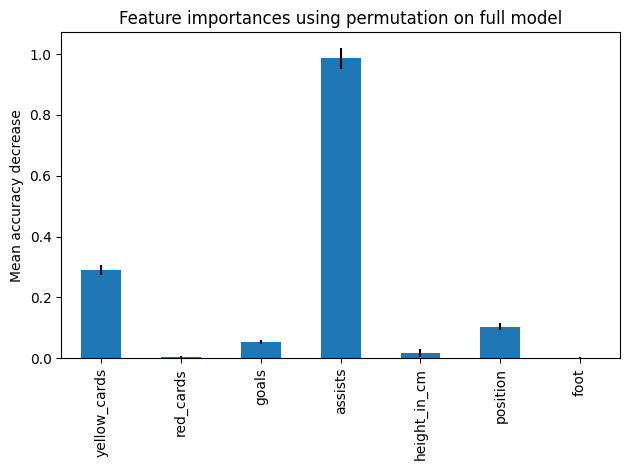

In [202]:
# Feature Importance
result = permutation_importance(
    rf, X_test, y_test, random_state=1
)
feature_names = ['yellow_cards', 'red_cards', 'goals', 'assists', 'height_in_cm', 'position', 'foot']
rf_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
rf_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [203]:
# SVM
scaler = StandardScaler()
scaler.fit(X_train[['yellow_cards', 'red_cards', 'goals', 'assists', 'height_in_cm', 'position', 'foot']])

X_train[['yellow_cards', 'red_cards', 'goals', 'assists', 'height_in_cm', 'position', 'foot']] = scaler.transform(X_train[['yellow_cards', 'red_cards', 'goals', 'assists', 'height_in_cm', 'position', 'foot']])

svm = SVC()
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print('The accuracy of the model is: {}'.format(svm.score(X_test, y_test)))

The accuracy of the model is: 0.0467642178307437
